# Importando Bibliotecas

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

# Funções Auxiliares

In [16]:
def dataFrame_to_boxPlot(dataFrame,var):
    data = {}
    column_value = []
    column_x = []

    for column in range(len(dataFrame.columns)):
        column_value += list(dataFrame.iloc[:,column])
        column_x += [f'x{column+1}' for i in range(len(dataFrame))]

    data[var]=column_value
    data['x']=column_x
    return pd.DataFrame(data)

In [17]:
def describe_var(dataframe,var):
    resultado_var = {}
    
    for periodo in range(len(dataframe.iloc[0,0])):
        aux = []
        for list in dataframe[var]:
            aux.append(list[periodo])
        resultado_var[f'{var}{periodo+1}'] = aux

    return pd.DataFrame(resultado_var)

# Importando Dados

In [18]:
past = 'C:/Users/marcio/Documents/Prev_For_ULS/Resultados/tabelas/Previsoes/'

In [19]:
previsoes_np = {}
previsoes = []
for index in range(3):
    with open(past+f'Prev_pro/Previsao_pro{index}.txt', "r") as arquivo:
	    previsoes.append([float(demanda) for demanda in arquivo.read().split(',')])
            
previsoes_np['demandas'] = previsoes
previsoes_np = pd.DataFrame(previsoes_np)
previsoes_np.head()


,demandas
0,"[89.08585357666016, 89.50004577636719, 89.8959..."
1,"[89.10758209228516, 89.27462768554688, 89.6483..."
2,"[89.00076293945312, 89.16638946533203, 89.4610..."


In [20]:
previsoes_ar = {}
previsoes = []
for index in range(3):
    with open(past+f'Prev_ari/Previsao_ari{index}.txt', "r") as arquivo:
	    previsoes.append([float(demanda) for demanda in arquivo.read().split(',')])
            
previsoes_ar['demandas'] = previsoes
previsoes_ar = pd.DataFrame(previsoes_ar)

In [28]:
df_demandas = pd.read_csv('C:/Users/marcio/Documents/Prev_For_ULS/Resultados/tabelas/Demandas_treinamento/demandas')[['date','demandas']]

demandas_treino = df_demandas['demandas']
demandas_treino.head()

0    90
1    89
2    90
3    90
4    92
Name: demandas, dtype: int64

In [22]:
demandas = {}
demandas_aux = []
for i in range(0,int(len(demandas_treino)/52)):
    demandas_aux.append(list(demandas_treino[i*52:(i+1)*52].values))
demandas['demandas'] = demandas_aux
demandas = pd.DataFrame(demandas)

In [23]:
with open('C:/Users/marcio/Documents/Prev_For_ULS/Resultados/tabelas/Prev_teste/test_arima.txt', "r") as arquivo:
	test_ar = [float(demanda) for demanda in arquivo.read().split(',')]

with open('C:/Users/marcio/Documents/Prev_For_ULS/Resultados/tabelas/Prev_teste/test_pro.txt', "r") as arquivo:
	test_np = [float(demanda) for demanda in arquivo.read().split(',')]


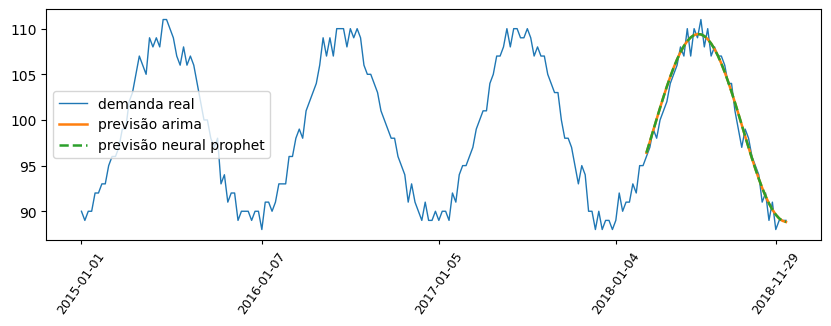

In [42]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(1,1,1)

plt.plot(df_demandas.date,df_demandas.demandas,label='demanda real', linewidth=1)
plt.plot(df_demandas.date.iloc[166:],test_ar,label='previsão arima', linestyle='-',linewidth=1.8)
plt.plot(df_demandas.date.iloc[166:],test_ar,label='previsão neural prophet',linestyle='--', linewidth=1.8)
plt.xticks([df_demandas.date.values[i] for i in [0,53,105,157,204]])
plt.tick_params(axis='x', labelsize=9, length=3)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.legend()


plt.savefig('C:/Users/marcio/Documents/Prev_For_ULS/Resultados/img/prev_testes.png', bbox_inches='tight',pad_inches = 0.1,format='png')


# Analise Das Previsões

In [25]:
previsao_demanda_np = describe_var(previsoes_np,'demandas')
previsao_demanda_ar = describe_var(previsoes_ar,'demandas')
demandas_d = describe_var(demandas,'demandas')

In [26]:
boxPlot_previsao_np = dataFrame_to_boxPlot(previsao_demanda_np,'demandas')
boxPlot_previsao_ar = dataFrame_to_boxPlot(previsao_demanda_ar,'demandas')
boxPlot_demandas = dataFrame_to_boxPlot(demandas_d,'demandas')

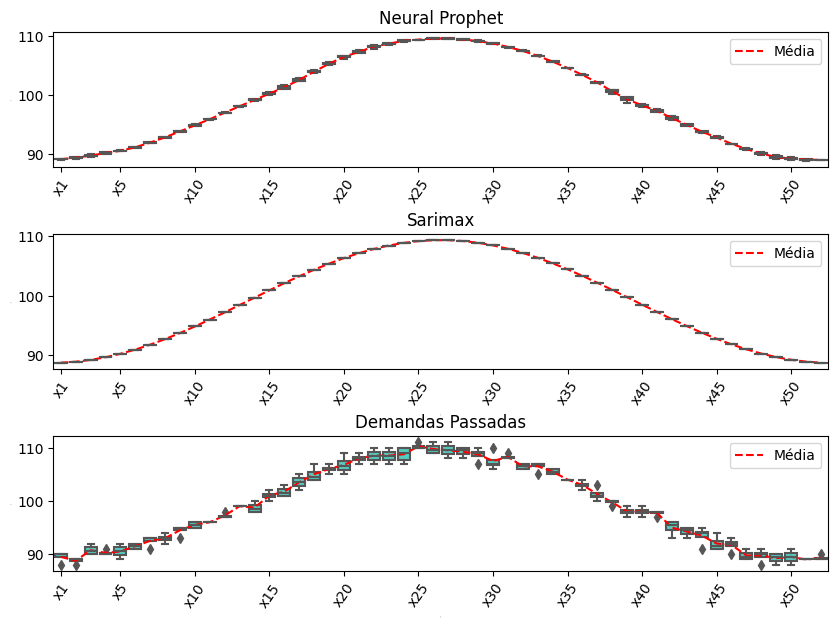

In [27]:
fig=plt.figure(figsize=(10,7))
#fig.suptitle('Distribuição das Previsões de Demandas por Período')



plt.subplots_adjust(wspace=0, hspace=0.5)

ax=fig.add_subplot(3,1,1)
ax.set_title('Neural Prophet')
sns.boxplot(data=boxPlot_previsao_np,x='x',y='demandas',color='turquoise')
plt.plot(previsao_demanda_np.columns,previsao_demanda_np.describe().iloc[1,:],color='red',linestyle='--',label='Média')
plt.xlabel([], fontsize=0)
plt.ylabel([], fontsize=0)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.xticks([0]+[i*5-1 for i in range(1,int(len(previsao_demanda_np.columns)/5)+1)])
plt.legend()


ax=fig.add_subplot(3,1,2)
ax.set_title('Sarimax')
sns.boxplot(data=boxPlot_previsao_ar,x='x',y='demandas',color='turquoise')
plt.plot(previsao_demanda_np.columns,previsao_demanda_ar.describe().iloc[1,:],color='red',linestyle='--',label='Média')
plt.xlabel([], fontsize=0)
plt.ylabel([], fontsize=0)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.xticks([0]+[i*5-1 for i in range(1,int(len(previsao_demanda_ar.columns)/5)+1)])
plt.legend()


ax=fig.add_subplot(3,1,3)
ax.set_title('Demandas Passadas')
sns.boxplot(data=boxPlot_demandas,x='x',y='demandas',color='turquoise')
plt.plot(demandas_d.columns,demandas_d.describe().iloc[1,:],color='red',linestyle='--',label='Média')
plt.xlabel([], fontsize=0)
plt.ylabel([], fontsize=0)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.xticks([0]+[i*5-1 for i in range(1,int(len(demandas_d.columns)/5)+1)])
plt.legend()

plt.savefig('C:/Users/marcio/Documents/Prev_For_ULS/Resultados/img/Previsoes.png', format='png', bbox_inches='tight',pad_inches = 0.1)